In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

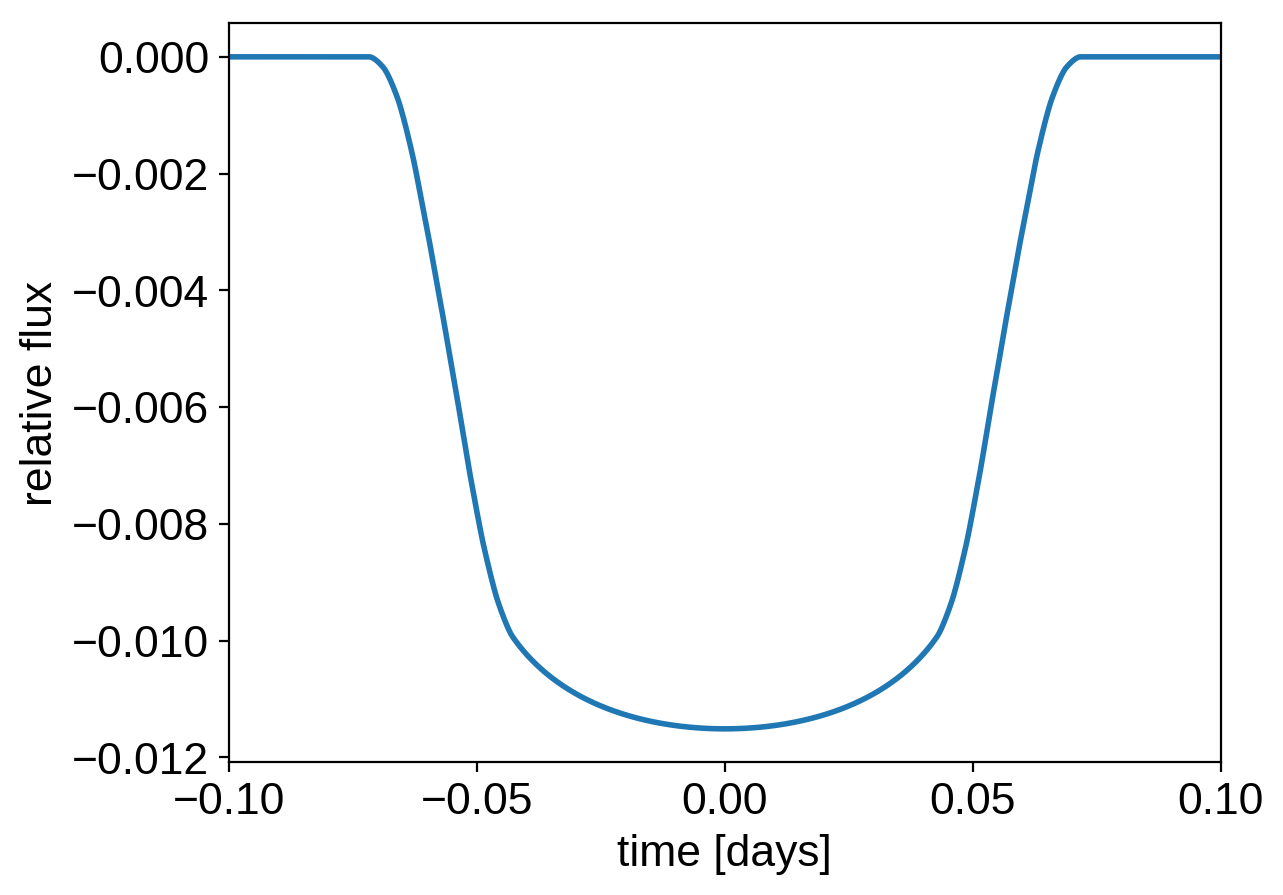

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02).eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06]))
    b = xo.distributions.ImpactParameter("b", ror=r, shape=2, testval=np.random.rand(2))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.478798e+04]

1it [00:00, 165.05it/s, logp=2.478798e+04]

2it [00:00, 237.94it/s, logp=2.478798e+04]

3it [00:00, 270.21it/s, logp=-4.973052e+09]

4it [00:00, 300.60it/s, logp=2.478859e+04] 

5it [00:00, 312.60it/s, logp=2.478913e+04]

6it [00:00, 327.51it/s, logp=2.478977e+04]

7it [00:00, 337.44it/s, logp=2.479074e+04]

8it [00:00, 346.61it/s, logp=2.478483e+04]

9it [00:00, 356.43it/s, logp=2.479082e+04]

10it [00:00, 357.70it/s, logp=2.479098e+04]

11it [00:00, 359.17it/s, logp=2.479151e+04]

12it [00:00, 361.03it/s, logp=2.479065e+04]

13it [00:00, 366.09it/s, logp=2.479174e+04]

14it [00:00, 365.99it/s, logp=2.479145e+04]

15it [00:00, 367.32it/s, logp=2.479182e+04]

16it [00:00, 369.00it/s, logp=2.479195e+04]

17it [00:00, 372.59it/s, logp=2.479239e+04]

18it [00:00, 374.36it/s, logp=2.479094e+04]

19it [00:00, 375.79it/s, logp=2.479253e+04]

20it [00:00, 375.90it/s, logp=2.479279e+04]

21it [00:00, 376.05it/s, logp=2.479323e+04]

22it [00:00, 376.13it/s, logp=2.479351e+04]

23it [00:00, 376.07it/s, logp=2.479354e+04]

24it [00:00, 375.88it/s, logp=2.479354e+04]

25it [00:00, 376.15it/s, logp=2.479354e+04]

26it [00:00, 375.14it/s, logp=2.479354e+04]

27it [00:00, 374.80it/s, logp=2.479354e+04]

28it [00:00, 375.28it/s, logp=2.479354e+04]

29it [00:00, 375.71it/s, logp=2.479354e+04]

30it [00:00, 375.43it/s, logp=2.479354e+04]

31it [00:00, 375.42it/s, logp=2.479354e+04]

32it [00:00, 376.83it/s, logp=2.479354e+04]

33it [00:00, 377.45it/s, logp=2.479354e+04]

34it [00:00, 377.97it/s, logp=2.479354e+04]

35it [00:00, 378.97it/s, logp=2.479354e+04]

36it [00:00, 379.50it/s, logp=2.479354e+04]

37it [00:00, 381.02it/s, logp=2.479354e+04]

38it [00:00, 382.25it/s, logp=2.479354e+04]

39it [00:00, 389.99it/s, logp=2.479354e+04]

39it [00:00, 389.99it/s, logp=2.479354e+04]

40it [00:00, 389.99it/s, logp=2.479354e+04]

41it [00:00, 389.99it/s, logp=2.479354e+04]

42it [00:00, 389.99it/s, logp=2.479354e+04]

43it [00:00, 389.99it/s, logp=2.479354e+04]

44it [00:00, 389.99it/s, logp=2.479354e+04]

45it [00:00, 389.99it/s, logp=2.479354e+04]

46it [00:00, 389.99it/s, logp=2.479354e+04]

47it [00:00, 389.99it/s, logp=2.479354e+04]

48it [00:00, 389.99it/s, logp=2.479354e+04]

49it [00:00, 389.99it/s, logp=2.479354e+04]

50it [00:00, 389.99it/s, logp=2.479354e+04]

51it [00:00, 389.99it/s, logp=2.479354e+04]

52it [00:00, 389.99it/s, logp=2.479354e+04]

53it [00:00, 389.99it/s, logp=2.479354e+04]

54it [00:00, 389.99it/s, logp=2.479354e+04]

55it [00:00, 389.99it/s, logp=2.479354e+04]

56it [00:00, 389.99it/s, logp=2.479354e+04]

57it [00:00, 389.99it/s, logp=2.479354e+04]

58it [00:00, 389.99it/s, logp=2.479354e+04]

59it [00:00, 389.99it/s, logp=2.479354e+04]

60it [00:00, 389.99it/s, logp=2.479354e+04]

61it [00:00, 389.99it/s, logp=2.479354e+04]

62it [00:00, 389.99it/s, logp=2.479354e+04]

63it [00:00, 389.99it/s, logp=2.479354e+04]

64it [00:00, 389.99it/s, logp=2.479354e+04]

65it [00:00, 389.99it/s, logp=2.479354e+04]

66it [00:00, 389.99it/s, logp=2.479354e+04]

67it [00:00, 389.99it/s, logp=2.479354e+04]

68it [00:00, 389.99it/s, logp=2.479354e+04]

69it [00:00, 389.99it/s, logp=2.479354e+04]

70it [00:00, 389.99it/s, logp=2.479354e+04]

71it [00:00, 389.99it/s, logp=2.479354e+04]

72it [00:00, 389.99it/s, logp=2.479354e+04]

73it [00:00, 389.99it/s, logp=2.479354e+04]

74it [00:00, 389.99it/s, logp=2.479354e+04]

75it [00:00, 389.99it/s, logp=2.479354e+04]

76it [00:00, 389.99it/s, logp=2.479354e+04]

77it [00:00, 389.99it/s, logp=2.479354e+04]

78it [00:00, 389.99it/s, logp=2.479354e+04]

79it [00:00, 389.99it/s, logp=2.479354e+04]

80it [00:00, 389.99it/s, logp=2.479354e+04]

81it [00:00, 389.99it/s, logp=2.479354e+04]

82it [00:00, 389.99it/s, logp=2.479354e+04]

83it [00:00, 389.99it/s, logp=2.479354e+04]

84it [00:00, 389.99it/s, logp=2.479354e+04]

85it [00:00, 408.10it/s, logp=2.479354e+04]

85it [00:00, 408.10it/s, logp=2.479354e+04]

86it [00:00, 408.10it/s, logp=2.479354e+04]

87it [00:00, 408.10it/s, logp=2.479354e+04]

88it [00:00, 408.10it/s, logp=2.479354e+04]

89it [00:00, 408.10it/s, logp=2.479354e+04]

90it [00:00, 408.10it/s, logp=2.479354e+04]

91it [00:00, 408.10it/s, logp=2.479354e+04]

92it [00:00, 408.10it/s, logp=2.479354e+04]

93it [00:00, 408.10it/s, logp=2.479354e+04]

94it [00:00, 408.10it/s, logp=2.479354e+04]

95it [00:00, 408.10it/s, logp=2.479354e+04]

96it [00:00, 408.10it/s, logp=2.479354e+04]

97it [00:00, 408.10it/s, logp=2.479354e+04]

98it [00:00, 408.10it/s, logp=2.479354e+04]

99it [00:05, 18.14it/s, logp=2.479354e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807487 -> 24793.5394256112


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

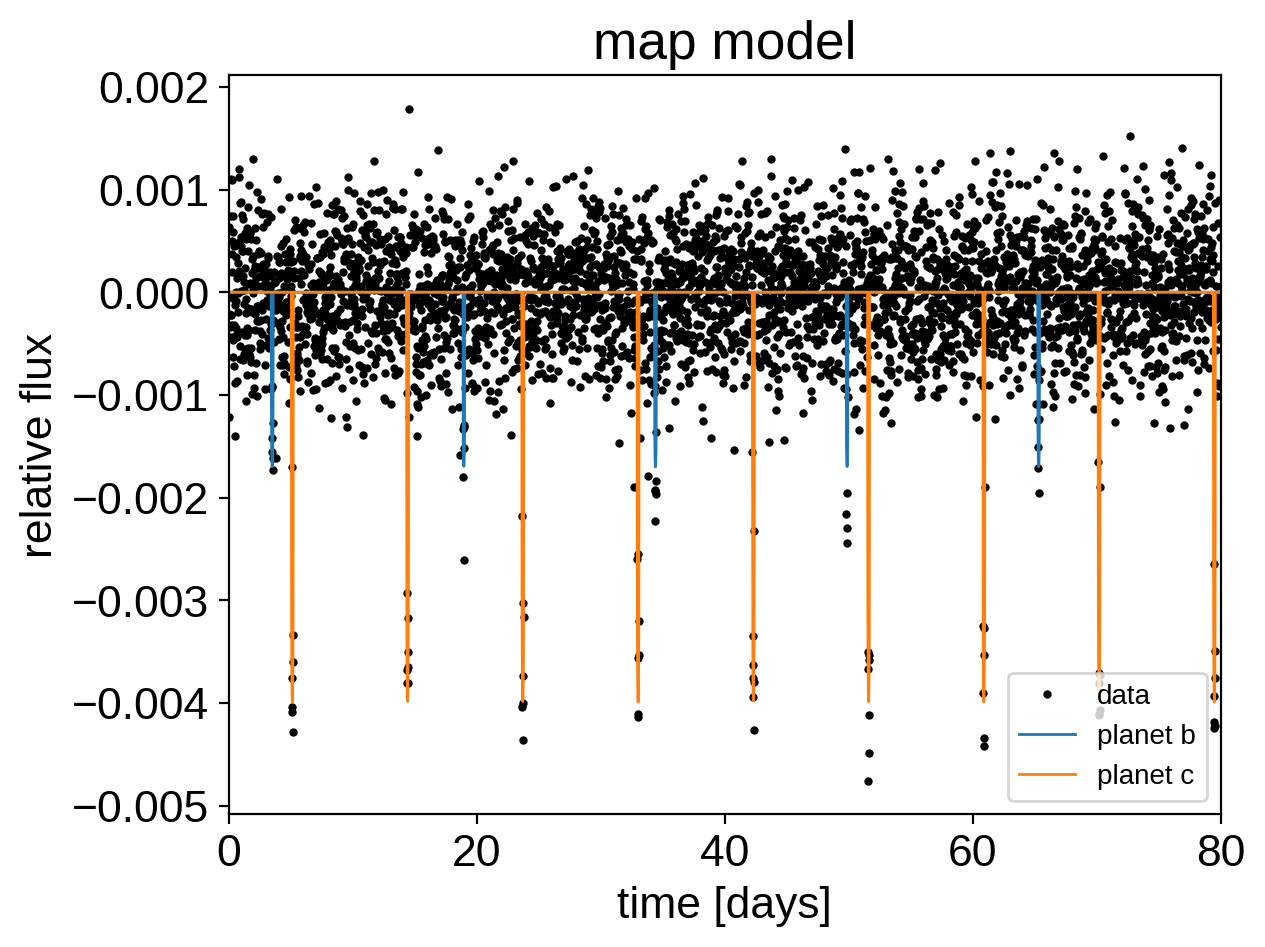

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [b, r, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/24000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/24000 [00:00<02:52, 138.63draws/s]

Sampling 4 chains:   0%|          | 26/24000 [00:00<05:13, 76.42draws/s] 

Sampling 4 chains:   0%|          | 31/24000 [00:00<07:21, 54.33draws/s]

Sampling 4 chains:   0%|          | 35/24000 [00:00<09:10, 43.50draws/s]

Sampling 4 chains:   0%|          | 39/24000 [00:00<10:17, 38.79draws/s]

Sampling 4 chains:   0%|          | 43/24000 [00:00<10:53, 36.66draws/s]

Sampling 4 chains:   0%|          | 47/24000 [00:00<11:18, 35.30draws/s]

Sampling 4 chains:   0%|          | 51/24000 [00:01<11:50, 33.72draws/s]

Sampling 4 chains:   0%|          | 55/24000 [00:01<11:43, 34.03draws/s]

Sampling 4 chains:   0%|          | 59/24000 [00:01<11:51, 33.65draws/s]

Sampling 4 chains:   0%|          | 63/24000 [00:01<11:55, 33.45draws/s]

Sampling 4 chains:   0%|          | 67/24000 [00:01<11:57, 33.37draws/s]

Sampling 4 chains:   0%|          | 71/24000 [00:01<11:59, 33.27draws/s]

Sampling 4 chains:   0%|          | 75/24000 [00:01<12:01, 33.17draws/s]

Sampling 4 chains:   0%|          | 79/24000 [00:01<12:01, 33.16draws/s]

Sampling 4 chains:   0%|          | 83/24000 [00:02<12:02, 33.10draws/s]

Sampling 4 chains:   0%|          | 88/24000 [00:02<11:20, 35.15draws/s]

Sampling 4 chains:   0%|          | 92/24000 [00:02<11:09, 35.71draws/s]

Sampling 4 chains:   0%|          | 96/24000 [00:02<11:46, 33.82draws/s]

Sampling 4 chains:   0%|          | 100/24000 [00:02<12:07, 32.85draws/s]

Sampling 4 chains:   0%|          | 104/24000 [00:02<12:09, 32.78draws/s]

Sampling 4 chains:   0%|          | 108/24000 [00:02<12:12, 32.60draws/s]

Sampling 4 chains:   0%|          | 112/24000 [00:02<12:11, 32.66draws/s]

Sampling 4 chains:   0%|          | 116/24000 [00:03<12:10, 32.71draws/s]

Sampling 4 chains:   0%|          | 120/24000 [00:03<12:11, 32.67draws/s]

Sampling 4 chains:   1%|          | 124/24000 [00:03<12:15, 32.47draws/s]

Sampling 4 chains:   1%|          | 128/24000 [00:03<12:11, 32.62draws/s]

Sampling 4 chains:   1%|          | 132/24000 [00:03<12:22, 32.16draws/s]

Sampling 4 chains:   1%|          | 137/24000 [00:03<12:11, 32.62draws/s]

Sampling 4 chains:   1%|          | 142/24000 [00:03<11:43, 33.93draws/s]

Sampling 4 chains:   1%|          | 147/24000 [00:03<11:36, 34.25draws/s]

Sampling 4 chains:   1%|          | 151/24000 [00:04<11:46, 33.78draws/s]

Sampling 4 chains:   1%|          | 155/24000 [00:04<11:50, 33.54draws/s]

Sampling 4 chains:   1%|          | 159/24000 [00:04<11:52, 33.46draws/s]

Sampling 4 chains:   1%|          | 163/24000 [00:04<12:32, 31.66draws/s]

Sampling 4 chains:   1%|          | 167/24000 [00:04<12:45, 31.14draws/s]

Sampling 4 chains:   1%|          | 171/24000 [00:04<12:53, 30.80draws/s]

Sampling 4 chains:   1%|          | 175/24000 [00:04<12:37, 31.47draws/s]

Sampling 4 chains:   1%|          | 179/24000 [00:04<12:27, 31.85draws/s]

Sampling 4 chains:   1%|          | 183/24000 [00:05<12:22, 32.08draws/s]

Sampling 4 chains:   1%|          | 187/24000 [00:05<12:13, 32.45draws/s]

Sampling 4 chains:   1%|          | 191/24000 [00:05<12:08, 32.70draws/s]

Sampling 4 chains:   1%|          | 195/24000 [00:05<12:06, 32.78draws/s]

Sampling 4 chains:   1%|          | 199/24000 [00:05<12:04, 32.83draws/s]

Sampling 4 chains:   1%|          | 203/24000 [00:05<12:04, 32.83draws/s]

Sampling 4 chains:   1%|          | 207/24000 [00:05<12:10, 32.59draws/s]

Sampling 4 chains:   1%|          | 211/24000 [00:05<12:17, 32.26draws/s]

Sampling 4 chains:   1%|          | 215/24000 [00:06<12:32, 31.63draws/s]

Sampling 4 chains:   1%|          | 219/24000 [00:06<12:30, 31.70draws/s]

Sampling 4 chains:   1%|          | 223/24000 [00:06<12:37, 31.40draws/s]

Sampling 4 chains:   1%|          | 227/24000 [00:06<13:08, 30.15draws/s]

Sampling 4 chains:   1%|          | 231/24000 [00:06<13:10, 30.07draws/s]

Sampling 4 chains:   1%|          | 235/24000 [00:06<13:15, 29.86draws/s]

Sampling 4 chains:   1%|          | 239/24000 [00:06<13:12, 29.97draws/s]

Sampling 4 chains:   1%|          | 243/24000 [00:07<13:24, 29.53draws/s]

Sampling 4 chains:   1%|          | 247/24000 [00:07<13:12, 29.95draws/s]

Sampling 4 chains:   1%|          | 251/24000 [00:07<13:05, 30.25draws/s]

Sampling 4 chains:   1%|          | 255/24000 [00:07<12:55, 30.60draws/s]

Sampling 4 chains:   1%|          | 259/24000 [00:07<12:53, 30.71draws/s]

Sampling 4 chains:   1%|          | 263/24000 [00:07<12:48, 30.89draws/s]

Sampling 4 chains:   1%|          | 267/24000 [00:07<12:55, 30.60draws/s]

Sampling 4 chains:   1%|          | 271/24000 [00:07<13:34, 29.12draws/s]

Sampling 4 chains:   1%|          | 275/24000 [00:08<13:05, 30.20draws/s]

Sampling 4 chains:   1%|          | 279/24000 [00:08<12:45, 30.98draws/s]

Sampling 4 chains:   1%|          | 283/24000 [00:08<12:29, 31.64draws/s]

Sampling 4 chains:   1%|          | 287/24000 [00:08<12:18, 32.09draws/s]

Sampling 4 chains:   1%|          | 291/24000 [00:08<12:11, 32.43draws/s]

Sampling 4 chains:   1%|          | 295/24000 [00:08<12:06, 32.64draws/s]

Sampling 4 chains:   1%|          | 299/24000 [00:08<12:17, 32.14draws/s]

Sampling 4 chains:   1%|▏         | 304/24000 [00:08<11:57, 33.03draws/s]

Sampling 4 chains:   1%|▏         | 308/24000 [00:09<11:54, 33.14draws/s]

Sampling 4 chains:   1%|▏         | 312/24000 [00:09<11:59, 32.94draws/s]

Sampling 4 chains:   1%|▏         | 316/24000 [00:09<12:04, 32.67draws/s]

Sampling 4 chains:   1%|▏         | 320/24000 [00:09<12:31, 31.52draws/s]

Sampling 4 chains:   1%|▏         | 324/24000 [00:09<12:22, 31.89draws/s]

Sampling 4 chains:   1%|▏         | 328/24000 [00:09<12:14, 32.24draws/s]

Sampling 4 chains:   1%|▏         | 332/24000 [00:09<12:07, 32.51draws/s]

Sampling 4 chains:   1%|▏         | 336/24000 [00:09<12:15, 32.18draws/s]

Sampling 4 chains:   1%|▏         | 340/24000 [00:10<12:38, 31.21draws/s]

Sampling 4 chains:   1%|▏         | 344/24000 [00:10<12:26, 31.68draws/s]

Sampling 4 chains:   1%|▏         | 348/24000 [00:10<12:19, 31.98draws/s]

Sampling 4 chains:   1%|▏         | 352/24000 [00:10<12:12, 32.28draws/s]

Sampling 4 chains:   1%|▏         | 356/24000 [00:10<12:30, 31.51draws/s]

Sampling 4 chains:   2%|▏         | 360/24000 [00:10<12:46, 30.84draws/s]

Sampling 4 chains:   2%|▏         | 364/24000 [00:10<13:03, 30.15draws/s]

Sampling 4 chains:   2%|▏         | 368/24000 [00:10<12:45, 30.87draws/s]

Sampling 4 chains:   2%|▏         | 372/24000 [00:11<12:35, 31.29draws/s]

Sampling 4 chains:   2%|▏         | 376/24000 [00:11<12:52, 30.57draws/s]

Sampling 4 chains:   2%|▏         | 380/24000 [00:11<12:41, 31.03draws/s]

Sampling 4 chains:   2%|▏         | 384/24000 [00:11<12:33, 31.32draws/s]

Sampling 4 chains:   2%|▏         | 388/24000 [00:11<12:23, 31.77draws/s]

Sampling 4 chains:   2%|▏         | 392/24000 [00:11<12:17, 31.99draws/s]

Sampling 4 chains:   2%|▏         | 396/24000 [00:11<12:37, 31.18draws/s]

Sampling 4 chains:   2%|▏         | 400/24000 [00:11<12:32, 31.35draws/s]

Sampling 4 chains:   2%|▏         | 404/24000 [00:12<12:26, 31.61draws/s]

Sampling 4 chains:   2%|▏         | 408/24000 [00:12<12:28, 31.53draws/s]

Sampling 4 chains:   2%|▏         | 412/24000 [00:12<12:25, 31.64draws/s]

Sampling 4 chains:   2%|▏         | 416/24000 [00:12<12:21, 31.79draws/s]

Sampling 4 chains:   2%|▏         | 420/24000 [00:12<12:16, 32.00draws/s]

Sampling 4 chains:   2%|▏         | 424/24000 [00:12<12:16, 32.02draws/s]

Sampling 4 chains:   2%|▏         | 428/24000 [00:12<12:16, 32.00draws/s]

Sampling 4 chains:   2%|▏         | 432/24000 [00:12<12:15, 32.05draws/s]

Sampling 4 chains:   2%|▏         | 436/24000 [00:13<12:12, 32.16draws/s]

Sampling 4 chains:   2%|▏         | 440/24000 [00:13<12:15, 32.05draws/s]

Sampling 4 chains:   2%|▏         | 444/24000 [00:13<12:15, 32.04draws/s]

Sampling 4 chains:   2%|▏         | 448/24000 [00:13<12:21, 31.76draws/s]

Sampling 4 chains:   2%|▏         | 452/24000 [00:13<13:26, 29.18draws/s]

Sampling 4 chains:   2%|▏         | 456/24000 [00:13<13:11, 29.76draws/s]

Sampling 4 chains:   2%|▏         | 460/24000 [00:13<12:57, 30.27draws/s]

Sampling 4 chains:   2%|▏         | 464/24000 [00:14<12:47, 30.65draws/s]

Sampling 4 chains:   2%|▏         | 468/24000 [00:14<12:43, 30.83draws/s]

Sampling 4 chains:   2%|▏         | 472/24000 [00:14<12:37, 31.04draws/s]

Sampling 4 chains:   2%|▏         | 476/24000 [00:14<12:59, 30.16draws/s]

Sampling 4 chains:   2%|▏         | 480/24000 [00:14<12:45, 30.74draws/s]

Sampling 4 chains:   2%|▏         | 484/24000 [00:14<12:30, 31.32draws/s]

Sampling 4 chains:   2%|▏         | 488/24000 [00:14<12:22, 31.66draws/s]

Sampling 4 chains:   2%|▏         | 492/24000 [00:14<12:16, 31.92draws/s]

Sampling 4 chains:   2%|▏         | 496/24000 [00:15<12:18, 31.84draws/s]

Sampling 4 chains:   2%|▏         | 500/24000 [00:15<12:16, 31.91draws/s]

Sampling 4 chains:   2%|▏         | 504/24000 [00:15<12:25, 31.50draws/s]

Sampling 4 chains:   2%|▏         | 508/24000 [00:15<12:44, 30.74draws/s]

Sampling 4 chains:   2%|▏         | 512/24000 [00:15<12:39, 30.94draws/s]

Sampling 4 chains:   2%|▏         | 516/24000 [00:15<12:25, 31.52draws/s]

Sampling 4 chains:   2%|▏         | 520/24000 [00:15<12:15, 31.94draws/s]

Sampling 4 chains:   2%|▏         | 524/24000 [00:15<12:06, 32.29draws/s]

Sampling 4 chains:   2%|▏         | 528/24000 [00:16<12:03, 32.43draws/s]

Sampling 4 chains:   2%|▏         | 532/24000 [00:16<11:59, 32.62draws/s]

Sampling 4 chains:   2%|▏         | 536/24000 [00:16<11:58, 32.63draws/s]

Sampling 4 chains:   2%|▏         | 540/24000 [00:16<11:56, 32.76draws/s]

Sampling 4 chains:   2%|▏         | 544/24000 [00:16<11:53, 32.88draws/s]

Sampling 4 chains:   2%|▏         | 548/24000 [00:16<11:53, 32.87draws/s]

Sampling 4 chains:   2%|▏         | 552/24000 [00:16<11:52, 32.92draws/s]

Sampling 4 chains:   2%|▏         | 556/24000 [00:16<11:50, 33.00draws/s]

Sampling 4 chains:   2%|▏         | 560/24000 [00:17<11:48, 33.07draws/s]

Sampling 4 chains:   2%|▏         | 564/24000 [00:17<11:47, 33.11draws/s]

Sampling 4 chains:   2%|▏         | 568/24000 [00:17<11:48, 33.09draws/s]

Sampling 4 chains:   2%|▏         | 572/24000 [00:17<11:48, 33.05draws/s]

Sampling 4 chains:   2%|▏         | 576/24000 [00:17<11:26, 34.14draws/s]

Sampling 4 chains:   2%|▏         | 580/24000 [00:17<11:06, 35.11draws/s]

Sampling 4 chains:   2%|▏         | 587/24000 [00:17<09:42, 40.21draws/s]

Sampling 4 chains:   2%|▏         | 592/24000 [00:17<10:09, 38.42draws/s]

Sampling 4 chains:   2%|▏         | 598/24000 [00:17<09:18, 41.92draws/s]

Sampling 4 chains:   3%|▎         | 605/24000 [00:18<08:16, 47.13draws/s]

Sampling 4 chains:   3%|▎         | 614/24000 [00:18<07:17, 53.44draws/s]

Sampling 4 chains:   3%|▎         | 624/24000 [00:18<06:17, 61.89draws/s]

Sampling 4 chains:   3%|▎         | 636/24000 [00:18<05:24, 72.08draws/s]

Sampling 4 chains:   3%|▎         | 658/24000 [00:18<04:20, 89.62draws/s]

Sampling 4 chains:   3%|▎         | 673/24000 [00:18<03:49, 101.44draws/s]

Sampling 4 chains:   3%|▎         | 694/24000 [00:18<03:21, 115.86draws/s]

Sampling 4 chains:   3%|▎         | 709/24000 [00:18<03:07, 124.05draws/s]

Sampling 4 chains:   3%|▎         | 739/24000 [00:18<02:35, 149.93draws/s]

Sampling 4 chains:   3%|▎         | 769/24000 [00:19<02:11, 176.12draws/s]

Sampling 4 chains:   3%|▎         | 802/24000 [00:19<01:53, 204.26draws/s]

Sampling 4 chains:   3%|▎         | 835/24000 [00:19<01:40, 230.23draws/s]

Sampling 4 chains:   4%|▎         | 877/24000 [00:19<01:27, 265.17draws/s]

Sampling 4 chains:   4%|▍         | 923/24000 [00:19<01:16, 302.64draws/s]

Sampling 4 chains:   4%|▍         | 960/24000 [00:19<01:12, 318.33draws/s]

Sampling 4 chains:   4%|▍         | 1001/24000 [00:19<01:07, 340.09draws/s]

Sampling 4 chains:   4%|▍         | 1052/24000 [00:19<01:00, 376.92draws/s]

Sampling 4 chains:   5%|▍         | 1103/24000 [00:19<00:56, 408.27draws/s]

Sampling 4 chains:   5%|▍         | 1148/24000 [00:19<00:55, 409.56draws/s]

Sampling 4 chains:   5%|▍         | 1192/24000 [00:20<00:54, 418.24draws/s]

Sampling 4 chains:   5%|▌         | 1236/24000 [00:20<00:53, 423.35draws/s]

Sampling 4 chains:   5%|▌         | 1281/24000 [00:20<00:52, 429.72draws/s]

Sampling 4 chains:   6%|▌         | 1334/24000 [00:20<00:49, 455.01draws/s]

Sampling 4 chains:   6%|▌         | 1386/24000 [00:20<00:47, 472.08draws/s]

Sampling 4 chains:   6%|▌         | 1435/24000 [00:20<00:48, 464.61draws/s]

Sampling 4 chains:   6%|▌         | 1483/24000 [00:20<00:48, 461.98draws/s]

Sampling 4 chains:   6%|▋         | 1537/24000 [00:20<00:46, 480.33draws/s]

Sampling 4 chains:   7%|▋         | 1587/24000 [00:20<00:46, 483.44draws/s]

Sampling 4 chains:   7%|▋         | 1636/24000 [00:20<00:46, 478.40draws/s]

Sampling 4 chains:   7%|▋         | 1685/24000 [00:21<00:47, 470.90draws/s]

Sampling 4 chains:   7%|▋         | 1733/24000 [00:21<00:47, 471.42draws/s]

Sampling 4 chains:   7%|▋         | 1787/24000 [00:21<00:45, 488.22draws/s]

Sampling 4 chains:   8%|▊         | 1841/24000 [00:21<00:44, 502.14draws/s]

Sampling 4 chains:   8%|▊         | 1893/24000 [00:21<00:43, 504.17draws/s]

Sampling 4 chains:   8%|▊         | 1944/24000 [00:21<00:45, 482.28draws/s]

Sampling 4 chains:   8%|▊         | 1999/24000 [00:21<00:44, 499.86draws/s]

Sampling 4 chains:   9%|▊         | 2051/24000 [00:21<00:43, 503.90draws/s]

Sampling 4 chains:   9%|▉         | 2102/24000 [00:21<00:43, 501.30draws/s]

Sampling 4 chains:   9%|▉         | 2153/24000 [00:22<00:44, 492.25draws/s]

Sampling 4 chains:   9%|▉         | 2203/24000 [00:22<00:45, 481.56draws/s]

Sampling 4 chains:   9%|▉         | 2252/24000 [00:22<00:45, 481.15draws/s]

Sampling 4 chains:  10%|▉         | 2301/24000 [00:22<00:45, 477.96draws/s]

Sampling 4 chains:  10%|▉         | 2354/24000 [00:22<00:44, 489.23draws/s]

Sampling 4 chains:  10%|█         | 2405/24000 [00:22<00:43, 493.33draws/s]

Sampling 4 chains:  10%|█         | 2464/24000 [00:22<00:41, 517.94draws/s]

Sampling 4 chains:  10%|█         | 2517/24000 [00:22<00:42, 509.31draws/s]

Sampling 4 chains:  11%|█         | 2570/24000 [00:22<00:41, 514.31draws/s]

Sampling 4 chains:  11%|█         | 2626/24000 [00:22<00:40, 526.14draws/s]

Sampling 4 chains:  11%|█         | 2679/24000 [00:23<00:41, 516.81draws/s]

Sampling 4 chains:  11%|█▏        | 2731/24000 [00:23<00:42, 501.30draws/s]

Sampling 4 chains:  12%|█▏        | 2782/24000 [00:23<00:42, 503.16draws/s]

Sampling 4 chains:  12%|█▏        | 2839/24000 [00:23<00:40, 519.84draws/s]

Sampling 4 chains:  12%|█▏        | 2892/24000 [00:23<00:40, 518.80draws/s]

Sampling 4 chains:  12%|█▏        | 2945/24000 [00:23<00:42, 498.88draws/s]

Sampling 4 chains:  12%|█▏        | 2996/24000 [00:23<00:42, 489.21draws/s]

Sampling 4 chains:  13%|█▎        | 3048/24000 [00:23<00:42, 497.64draws/s]

Sampling 4 chains:  13%|█▎        | 3106/24000 [00:23<00:40, 518.38draws/s]

Sampling 4 chains:  13%|█▎        | 3162/24000 [00:24<00:39, 528.33draws/s]

Sampling 4 chains:  13%|█▎        | 3216/24000 [00:24<00:40, 508.21draws/s]

Sampling 4 chains:  14%|█▎        | 3270/24000 [00:24<00:40, 513.38draws/s]

Sampling 4 chains:  14%|█▍        | 3322/24000 [00:24<00:41, 498.40draws/s]

Sampling 4 chains:  14%|█▍        | 3375/24000 [00:24<00:40, 506.79draws/s]

Sampling 4 chains:  14%|█▍        | 3426/24000 [00:24<00:41, 498.77draws/s]

Sampling 4 chains:  15%|█▍        | 3481/24000 [00:24<00:40, 512.45draws/s]

Sampling 4 chains:  15%|█▍        | 3534/24000 [00:24<00:39, 514.30draws/s]

Sampling 4 chains:  15%|█▍        | 3587/24000 [00:24<00:39, 515.72draws/s]

Sampling 4 chains:  15%|█▌        | 3643/24000 [00:24<00:38, 523.21draws/s]

Sampling 4 chains:  15%|█▌        | 3699/24000 [00:25<00:38, 531.58draws/s]

Sampling 4 chains:  16%|█▌        | 3753/24000 [00:25<00:39, 512.65draws/s]

Sampling 4 chains:  16%|█▌        | 3806/24000 [00:25<00:39, 514.66draws/s]

Sampling 4 chains:  16%|█▌        | 3860/24000 [00:25<00:38, 521.20draws/s]

Sampling 4 chains:  16%|█▋        | 3913/24000 [00:25<00:39, 511.96draws/s]

Sampling 4 chains:  17%|█▋        | 3972/24000 [00:25<00:37, 528.90draws/s]

Sampling 4 chains:  17%|█▋        | 4026/24000 [00:25<00:38, 516.94draws/s]

Sampling 4 chains:  17%|█▋        | 4078/24000 [00:25<00:38, 514.18draws/s]

Sampling 4 chains:  17%|█▋        | 4136/24000 [00:25<00:37, 532.15draws/s]

Sampling 4 chains:  17%|█▋        | 4194/24000 [00:25<00:36, 544.90draws/s]

Sampling 4 chains:  18%|█▊        | 4251/24000 [00:26<00:35, 550.15draws/s]

Sampling 4 chains:  18%|█▊        | 4307/24000 [00:26<00:36, 546.69draws/s]

Sampling 4 chains:  18%|█▊        | 4362/24000 [00:26<00:37, 527.81draws/s]

Sampling 4 chains:  18%|█▊        | 4416/24000 [00:26<00:37, 516.11draws/s]

Sampling 4 chains:  19%|█▊        | 4476/24000 [00:26<00:36, 538.45draws/s]

Sampling 4 chains:  19%|█▉        | 4531/24000 [00:26<00:36, 539.61draws/s]

Sampling 4 chains:  19%|█▉        | 4586/24000 [00:26<00:36, 526.60draws/s]

Sampling 4 chains:  19%|█▉        | 4639/24000 [00:26<00:37, 514.82draws/s]

Sampling 4 chains:  20%|█▉        | 4691/24000 [00:26<00:38, 504.46draws/s]

Sampling 4 chains:  20%|█▉        | 4744/24000 [00:27<00:37, 511.08draws/s]

Sampling 4 chains:  20%|█▉        | 4796/24000 [00:27<00:38, 499.51draws/s]

Sampling 4 chains:  20%|██        | 4851/24000 [00:27<00:37, 513.13draws/s]

Sampling 4 chains:  20%|██        | 4903/24000 [00:27<00:37, 503.72draws/s]

Sampling 4 chains:  21%|██        | 4954/24000 [00:27<00:38, 499.74draws/s]

Sampling 4 chains:  21%|██        | 5005/24000 [00:27<00:38, 498.41draws/s]

Sampling 4 chains:  21%|██        | 5060/24000 [00:27<00:37, 508.41draws/s]

Sampling 4 chains:  21%|██▏       | 5113/24000 [00:27<00:36, 512.89draws/s]

Sampling 4 chains:  22%|██▏       | 5167/24000 [00:27<00:36, 518.57draws/s]

Sampling 4 chains:  22%|██▏       | 5219/24000 [00:27<00:36, 517.07draws/s]

Sampling 4 chains:  22%|██▏       | 5271/24000 [00:28<00:36, 514.68draws/s]

Sampling 4 chains:  22%|██▏       | 5326/24000 [00:28<00:35, 524.10draws/s]

Sampling 4 chains:  22%|██▏       | 5380/24000 [00:28<00:35, 525.28draws/s]

Sampling 4 chains:  23%|██▎       | 5433/24000 [00:28<00:35, 526.53draws/s]

Sampling 4 chains:  23%|██▎       | 5486/24000 [00:28<00:35, 520.37draws/s]

Sampling 4 chains:  23%|██▎       | 5539/24000 [00:28<00:35, 521.65draws/s]

Sampling 4 chains:  23%|██▎       | 5592/24000 [00:28<00:35, 522.55draws/s]

Sampling 4 chains:  24%|██▎       | 5646/24000 [00:28<00:35, 523.44draws/s]

Sampling 4 chains:  24%|██▎       | 5699/24000 [00:28<00:35, 522.59draws/s]

Sampling 4 chains:  24%|██▍       | 5755/24000 [00:28<00:34, 532.98draws/s]

Sampling 4 chains:  24%|██▍       | 5809/24000 [00:29<00:34, 530.99draws/s]

Sampling 4 chains:  24%|██▍       | 5863/24000 [00:29<00:35, 511.79draws/s]

Sampling 4 chains:  25%|██▍       | 5918/24000 [00:29<00:34, 521.72draws/s]

Sampling 4 chains:  25%|██▍       | 5974/24000 [00:29<00:34, 523.90draws/s]

Sampling 4 chains:  25%|██▌       | 6027/24000 [00:29<00:35, 513.27draws/s]

Sampling 4 chains:  25%|██▌       | 6079/24000 [00:29<00:35, 510.51draws/s]

Sampling 4 chains:  26%|██▌       | 6131/24000 [00:29<00:36, 487.74draws/s]

Sampling 4 chains:  26%|██▌       | 6181/24000 [00:29<00:36, 488.83draws/s]

Sampling 4 chains:  26%|██▌       | 6238/24000 [00:29<00:34, 507.89draws/s]

Sampling 4 chains:  26%|██▌       | 6292/24000 [00:30<00:34, 516.85draws/s]

Sampling 4 chains:  26%|██▋       | 6344/24000 [00:30<00:34, 512.16draws/s]

Sampling 4 chains:  27%|██▋       | 6396/24000 [00:30<00:34, 512.04draws/s]

Sampling 4 chains:  27%|██▋       | 6449/24000 [00:30<00:34, 514.39draws/s]

Sampling 4 chains:  27%|██▋       | 6501/24000 [00:30<00:34, 503.54draws/s]

Sampling 4 chains:  27%|██▋       | 6554/24000 [00:30<00:34, 509.94draws/s]

Sampling 4 chains:  28%|██▊       | 6608/24000 [00:30<00:33, 515.76draws/s]

Sampling 4 chains:  28%|██▊       | 6660/24000 [00:30<00:33, 514.22draws/s]

Sampling 4 chains:  28%|██▊       | 6712/24000 [00:30<00:33, 514.26draws/s]

Sampling 4 chains:  28%|██▊       | 6765/24000 [00:30<00:33, 518.25draws/s]

Sampling 4 chains:  28%|██▊       | 6819/24000 [00:31<00:32, 523.13draws/s]

Sampling 4 chains:  29%|██▊       | 6874/24000 [00:31<00:32, 530.59draws/s]

Sampling 4 chains:  29%|██▉       | 6928/24000 [00:31<00:32, 532.49draws/s]

Sampling 4 chains:  29%|██▉       | 6982/24000 [00:31<00:32, 529.68draws/s]

Sampling 4 chains:  29%|██▉       | 7037/24000 [00:31<00:31, 534.43draws/s]

Sampling 4 chains:  30%|██▉       | 7091/24000 [00:31<00:31, 535.91draws/s]

Sampling 4 chains:  30%|██▉       | 7145/24000 [00:31<00:31, 527.54draws/s]

Sampling 4 chains:  30%|██▉       | 7198/24000 [00:31<00:32, 511.51draws/s]

Sampling 4 chains:  30%|███       | 7250/24000 [00:31<00:32, 507.76draws/s]

Sampling 4 chains:  30%|███       | 7301/24000 [00:32<00:33, 500.78draws/s]

Sampling 4 chains:  31%|███       | 7352/24000 [00:32<00:33, 491.31draws/s]

Sampling 4 chains:  31%|███       | 7404/24000 [00:32<00:33, 498.44draws/s]

Sampling 4 chains:  31%|███       | 7454/24000 [00:32<00:33, 498.52draws/s]

Sampling 4 chains:  31%|███▏      | 7504/24000 [00:32<00:33, 497.34draws/s]

Sampling 4 chains:  31%|███▏      | 7554/24000 [00:32<00:33, 496.78draws/s]

Sampling 4 chains:  32%|███▏      | 7604/24000 [00:32<00:33, 495.87draws/s]

Sampling 4 chains:  32%|███▏      | 7658/24000 [00:32<00:32, 507.08draws/s]

Sampling 4 chains:  32%|███▏      | 7709/24000 [00:32<00:32, 494.08draws/s]

Sampling 4 chains:  32%|███▏      | 7759/24000 [00:32<00:33, 477.78draws/s]

Sampling 4 chains:  33%|███▎      | 7810/24000 [00:33<00:33, 486.10draws/s]

Sampling 4 chains:  33%|███▎      | 7860/24000 [00:33<00:33, 488.29draws/s]

Sampling 4 chains:  33%|███▎      | 7910/24000 [00:33<00:32, 491.47draws/s]

Sampling 4 chains:  33%|███▎      | 7962/24000 [00:33<00:32, 499.41draws/s]

Sampling 4 chains:  33%|███▎      | 8013/24000 [00:33<00:32, 499.46draws/s]

Sampling 4 chains:  34%|███▎      | 8068/24000 [00:33<00:31, 509.41draws/s]

Sampling 4 chains:  34%|███▍      | 8121/24000 [00:33<00:30, 513.80draws/s]

Sampling 4 chains:  34%|███▍      | 8173/24000 [00:33<00:31, 508.86draws/s]

Sampling 4 chains:  34%|███▍      | 8224/24000 [00:33<00:31, 508.76draws/s]

Sampling 4 chains:  34%|███▍      | 8275/24000 [00:33<00:31, 497.57draws/s]

Sampling 4 chains:  35%|███▍      | 8327/24000 [00:34<00:31, 502.50draws/s]

Sampling 4 chains:  35%|███▍      | 8389/24000 [00:34<00:29, 531.58draws/s]

Sampling 4 chains:  35%|███▌      | 8447/24000 [00:34<00:28, 542.01draws/s]

Sampling 4 chains:  35%|███▌      | 8502/24000 [00:34<00:29, 523.64draws/s]

Sampling 4 chains:  36%|███▌      | 8555/24000 [00:34<00:30, 499.20draws/s]

Sampling 4 chains:  36%|███▌      | 8606/24000 [00:34<00:31, 489.77draws/s]

Sampling 4 chains:  36%|███▌      | 8656/24000 [00:34<00:31, 492.14draws/s]

Sampling 4 chains:  36%|███▋      | 8709/24000 [00:34<00:30, 501.29draws/s]

Sampling 4 chains:  37%|███▋      | 8761/24000 [00:34<00:30, 505.20draws/s]

Sampling 4 chains:  37%|███▋      | 8812/24000 [00:35<00:30, 500.24draws/s]

Sampling 4 chains:  37%|███▋      | 8864/24000 [00:35<00:30, 500.54draws/s]

Sampling 4 chains:  37%|███▋      | 8915/24000 [00:35<00:30, 498.70draws/s]

Sampling 4 chains:  37%|███▋      | 8966/24000 [00:35<00:30, 500.44draws/s]

Sampling 4 chains:  38%|███▊      | 9018/24000 [00:35<00:29, 506.08draws/s]

Sampling 4 chains:  38%|███▊      | 9070/24000 [00:35<00:29, 507.37draws/s]

Sampling 4 chains:  38%|███▊      | 9122/24000 [00:35<00:29, 509.39draws/s]

Sampling 4 chains:  38%|███▊      | 9173/24000 [00:35<00:29, 503.97draws/s]

Sampling 4 chains:  38%|███▊      | 9224/24000 [00:35<00:29, 499.32draws/s]

Sampling 4 chains:  39%|███▊      | 9274/24000 [00:35<00:29, 495.76draws/s]

Sampling 4 chains:  39%|███▉      | 9324/24000 [00:36<00:30, 486.20draws/s]

Sampling 4 chains:  39%|███▉      | 9373/24000 [00:36<00:30, 481.75draws/s]

Sampling 4 chains:  39%|███▉      | 9422/24000 [00:36<00:30, 480.27draws/s]

Sampling 4 chains:  39%|███▉      | 9471/24000 [00:36<00:30, 480.63draws/s]

Sampling 4 chains:  40%|███▉      | 9524/24000 [00:36<00:29, 493.33draws/s]

Sampling 4 chains:  40%|███▉      | 9575/24000 [00:36<00:29, 496.66draws/s]

Sampling 4 chains:  40%|████      | 9628/24000 [00:36<00:28, 505.32draws/s]

Sampling 4 chains:  40%|████      | 9679/24000 [00:36<00:28, 495.41draws/s]

Sampling 4 chains:  41%|████      | 9729/24000 [00:36<00:30, 472.28draws/s]

Sampling 4 chains:  41%|████      | 9777/24000 [00:36<00:31, 458.64draws/s]

Sampling 4 chains:  41%|████      | 9826/24000 [00:37<00:30, 459.67draws/s]

Sampling 4 chains:  41%|████      | 9874/24000 [00:37<00:30, 464.97draws/s]

Sampling 4 chains:  41%|████▏     | 9923/24000 [00:37<00:29, 471.83draws/s]

Sampling 4 chains:  42%|████▏     | 9972/24000 [00:37<00:29, 474.08draws/s]

Sampling 4 chains:  42%|████▏     | 10020/24000 [00:37<00:30, 453.56draws/s]

Sampling 4 chains:  42%|████▏     | 10072/24000 [00:37<00:29, 471.53draws/s]

Sampling 4 chains:  42%|████▏     | 10124/24000 [00:37<00:28, 484.96draws/s]

Sampling 4 chains:  42%|████▏     | 10175/24000 [00:37<00:28, 489.78draws/s]

Sampling 4 chains:  43%|████▎     | 10228/24000 [00:37<00:27, 500.08draws/s]

Sampling 4 chains:  43%|████▎     | 10279/24000 [00:38<00:27, 494.13draws/s]

Sampling 4 chains:  43%|████▎     | 10331/24000 [00:38<00:27, 500.41draws/s]

Sampling 4 chains:  43%|████▎     | 10384/24000 [00:38<00:26, 506.84draws/s]

Sampling 4 chains:  43%|████▎     | 10436/24000 [00:38<00:26, 508.69draws/s]

Sampling 4 chains:  44%|████▎     | 10489/24000 [00:38<00:26, 513.04draws/s]

Sampling 4 chains:  44%|████▍     | 10541/24000 [00:38<00:26, 510.67draws/s]

Sampling 4 chains:  44%|████▍     | 10594/24000 [00:38<00:25, 516.17draws/s]

Sampling 4 chains:  44%|████▍     | 10646/24000 [00:38<00:26, 505.11draws/s]

Sampling 4 chains:  45%|████▍     | 10697/24000 [00:38<00:26, 499.15draws/s]

Sampling 4 chains:  45%|████▍     | 10747/24000 [00:38<00:26, 494.06draws/s]

Sampling 4 chains:  45%|████▌     | 10800/24000 [00:39<00:26, 500.63draws/s]

Sampling 4 chains:  45%|████▌     | 10851/24000 [00:39<00:27, 481.47draws/s]

Sampling 4 chains:  45%|████▌     | 10905/24000 [00:39<00:26, 496.44draws/s]

Sampling 4 chains:  46%|████▌     | 10955/24000 [00:39<00:26, 491.82draws/s]

Sampling 4 chains:  46%|████▌     | 11006/24000 [00:39<00:26, 495.65draws/s]

Sampling 4 chains:  46%|████▌     | 11056/24000 [00:39<00:26, 491.54draws/s]

Sampling 4 chains:  46%|████▋     | 11106/24000 [00:39<00:26, 487.10draws/s]

Sampling 4 chains:  46%|████▋     | 11155/24000 [00:39<00:26, 485.02draws/s]

Sampling 4 chains:  47%|████▋     | 11212/24000 [00:39<00:25, 506.55draws/s]

Sampling 4 chains:  47%|████▋     | 11263/24000 [00:39<00:25, 494.81draws/s]

Sampling 4 chains:  47%|████▋     | 11317/24000 [00:40<00:25, 506.93draws/s]

Sampling 4 chains:  47%|████▋     | 11370/24000 [00:40<00:24, 509.71draws/s]

Sampling 4 chains:  48%|████▊     | 11422/24000 [00:40<00:24, 504.66draws/s]

Sampling 4 chains:  48%|████▊     | 11473/24000 [00:40<00:24, 502.01draws/s]

Sampling 4 chains:  48%|████▊     | 11525/24000 [00:40<00:24, 506.04draws/s]

Sampling 4 chains:  48%|████▊     | 11579/24000 [00:40<00:24, 511.76draws/s]

Sampling 4 chains:  48%|████▊     | 11631/24000 [00:40<00:24, 511.62draws/s]

Sampling 4 chains:  49%|████▊     | 11683/24000 [00:40<00:24, 507.56draws/s]

Sampling 4 chains:  49%|████▉     | 11734/24000 [00:40<00:24, 503.18draws/s]

Sampling 4 chains:  49%|████▉     | 11785/24000 [00:41<00:24, 504.86draws/s]

Sampling 4 chains:  49%|████▉     | 11836/24000 [00:41<00:24, 503.51draws/s]

Sampling 4 chains:  50%|████▉     | 11891/24000 [00:41<00:23, 514.83draws/s]

Sampling 4 chains:  50%|████▉     | 11944/24000 [00:41<00:23, 517.69draws/s]

Sampling 4 chains:  50%|████▉     | 11996/24000 [00:41<00:23, 505.09draws/s]

Sampling 4 chains:  50%|█████     | 12049/24000 [00:41<00:23, 509.45draws/s]

Sampling 4 chains:  50%|█████     | 12101/24000 [00:41<00:23, 510.57draws/s]

Sampling 4 chains:  51%|█████     | 12153/24000 [00:41<00:24, 491.94draws/s]

Sampling 4 chains:  51%|█████     | 12206/24000 [00:41<00:23, 500.39draws/s]

Sampling 4 chains:  51%|█████     | 12257/24000 [00:41<00:23, 498.72draws/s]

Sampling 4 chains:  51%|█████▏    | 12309/24000 [00:42<00:23, 504.57draws/s]

Sampling 4 chains:  52%|█████▏    | 12364/24000 [00:42<00:22, 513.93draws/s]

Sampling 4 chains:  52%|█████▏    | 12419/24000 [00:42<00:22, 521.57draws/s]

Sampling 4 chains:  52%|█████▏    | 12472/24000 [00:42<00:22, 522.73draws/s]

Sampling 4 chains:  52%|█████▏    | 12525/24000 [00:42<00:21, 524.87draws/s]

Sampling 4 chains:  52%|█████▏    | 12578/24000 [00:42<00:22, 514.72draws/s]

Sampling 4 chains:  53%|█████▎    | 12630/24000 [00:42<00:22, 502.31draws/s]

Sampling 4 chains:  53%|█████▎    | 12682/24000 [00:42<00:22, 506.12draws/s]

Sampling 4 chains:  53%|█████▎    | 12733/24000 [00:42<00:22, 497.19draws/s]

Sampling 4 chains:  53%|█████▎    | 12783/24000 [00:42<00:23, 481.83draws/s]

Sampling 4 chains:  53%|█████▎    | 12838/24000 [00:43<00:22, 498.54draws/s]

Sampling 4 chains:  54%|█████▎    | 12889/24000 [00:43<00:22, 498.17draws/s]

Sampling 4 chains:  54%|█████▍    | 12943/24000 [00:43<00:21, 507.49draws/s]

Sampling 4 chains:  54%|█████▍    | 12995/24000 [00:43<00:21, 510.87draws/s]

Sampling 4 chains:  54%|█████▍    | 13048/24000 [00:43<00:21, 515.90draws/s]

Sampling 4 chains:  55%|█████▍    | 13100/24000 [00:43<00:21, 504.82draws/s]

Sampling 4 chains:  55%|█████▍    | 13151/24000 [00:43<00:22, 486.26draws/s]

Sampling 4 chains:  55%|█████▌    | 13203/24000 [00:43<00:21, 495.19draws/s]

Sampling 4 chains:  55%|█████▌    | 13255/24000 [00:43<00:21, 501.60draws/s]

Sampling 4 chains:  55%|█████▌    | 13306/24000 [00:44<00:21, 500.66draws/s]

Sampling 4 chains:  56%|█████▌    | 13358/24000 [00:44<00:21, 504.43draws/s]

Sampling 4 chains:  56%|█████▌    | 13409/24000 [00:44<00:21, 500.06draws/s]

Sampling 4 chains:  56%|█████▌    | 13460/24000 [00:44<00:21, 480.01draws/s]

Sampling 4 chains:  56%|█████▋    | 13511/24000 [00:44<00:21, 486.88draws/s]

Sampling 4 chains:  57%|█████▋    | 13562/24000 [00:44<00:21, 491.72draws/s]

Sampling 4 chains:  57%|█████▋    | 13613/24000 [00:44<00:20, 497.03draws/s]

Sampling 4 chains:  57%|█████▋    | 13666/24000 [00:44<00:20, 506.37draws/s]

Sampling 4 chains:  57%|█████▋    | 13717/24000 [00:44<00:20, 489.96draws/s]

Sampling 4 chains:  57%|█████▋    | 13767/24000 [00:44<00:20, 491.62draws/s]

Sampling 4 chains:  58%|█████▊    | 13820/24000 [00:45<00:20, 500.92draws/s]

Sampling 4 chains:  58%|█████▊    | 13872/24000 [00:45<00:20, 505.79draws/s]

Sampling 4 chains:  58%|█████▊    | 13923/24000 [00:45<00:20, 495.16draws/s]

Sampling 4 chains:  58%|█████▊    | 13973/24000 [00:45<00:20, 494.17draws/s]

Sampling 4 chains:  58%|█████▊    | 14023/24000 [00:45<00:20, 486.66draws/s]

Sampling 4 chains:  59%|█████▊    | 14076/24000 [00:45<00:20, 495.73draws/s]

Sampling 4 chains:  59%|█████▉    | 14126/24000 [00:45<00:19, 494.16draws/s]

Sampling 4 chains:  59%|█████▉    | 14181/24000 [00:45<00:19, 505.49draws/s]

Sampling 4 chains:  59%|█████▉    | 14232/24000 [00:45<00:19, 504.70draws/s]

Sampling 4 chains:  60%|█████▉    | 14284/24000 [00:45<00:19, 501.20draws/s]

Sampling 4 chains:  60%|█████▉    | 14335/24000 [00:46<00:19, 503.76draws/s]

Sampling 4 chains:  60%|█████▉    | 14387/24000 [00:46<00:18, 507.29draws/s]

Sampling 4 chains:  60%|██████    | 14439/24000 [00:46<00:18, 509.14draws/s]

Sampling 4 chains:  60%|██████    | 14490/24000 [00:46<00:18, 503.08draws/s]

Sampling 4 chains:  61%|██████    | 14542/24000 [00:46<00:18, 503.94draws/s]

Sampling 4 chains:  61%|██████    | 14597/24000 [00:46<00:18, 516.71draws/s]

Sampling 4 chains:  61%|██████    | 14649/24000 [00:46<00:18, 513.44draws/s]

Sampling 4 chains:  61%|██████▏   | 14701/24000 [00:46<00:18, 513.56draws/s]

Sampling 4 chains:  61%|██████▏   | 14753/24000 [00:46<00:18, 507.67draws/s]

Sampling 4 chains:  62%|██████▏   | 14806/24000 [00:47<00:17, 513.12draws/s]

Sampling 4 chains:  62%|██████▏   | 14858/24000 [00:47<00:17, 511.71draws/s]

Sampling 4 chains:  62%|██████▏   | 14916/24000 [00:47<00:17, 526.86draws/s]

Sampling 4 chains:  62%|██████▏   | 14969/24000 [00:47<00:17, 524.05draws/s]

Sampling 4 chains:  63%|██████▎   | 15023/24000 [00:47<00:17, 524.61draws/s]

Sampling 4 chains:  63%|██████▎   | 15077/24000 [00:47<00:16, 527.58draws/s]

Sampling 4 chains:  63%|██████▎   | 15130/24000 [00:47<00:17, 506.25draws/s]

Sampling 4 chains:  63%|██████▎   | 15181/24000 [00:47<00:17, 499.69draws/s]

Sampling 4 chains:  63%|██████▎   | 15233/24000 [00:47<00:17, 501.92draws/s]

Sampling 4 chains:  64%|██████▎   | 15284/24000 [00:47<00:17, 499.69draws/s]

Sampling 4 chains:  64%|██████▍   | 15335/24000 [00:48<00:18, 473.64draws/s]

Sampling 4 chains:  64%|██████▍   | 15385/24000 [00:48<00:18, 474.97draws/s]

Sampling 4 chains:  64%|██████▍   | 15433/24000 [00:48<00:18, 461.25draws/s]

Sampling 4 chains:  64%|██████▍   | 15480/24000 [00:48<00:18, 454.59draws/s]

Sampling 4 chains:  65%|██████▍   | 15526/24000 [00:48<00:18, 448.07draws/s]

Sampling 4 chains:  65%|██████▍   | 15571/24000 [00:48<00:19, 441.19draws/s]

Sampling 4 chains:  65%|██████▌   | 15616/24000 [00:48<00:19, 423.65draws/s]

Sampling 4 chains:  65%|██████▌   | 15660/24000 [00:48<00:19, 426.36draws/s]

Sampling 4 chains:  65%|██████▌   | 15707/24000 [00:48<00:19, 434.44draws/s]

Sampling 4 chains:  66%|██████▌   | 15754/24000 [00:49<00:18, 441.23draws/s]

Sampling 4 chains:  66%|██████▌   | 15799/24000 [00:49<00:18, 439.43draws/s]

Sampling 4 chains:  66%|██████▌   | 15845/24000 [00:49<00:18, 445.37draws/s]

Sampling 4 chains:  66%|██████▌   | 15890/24000 [00:49<00:18, 441.15draws/s]

Sampling 4 chains:  66%|██████▋   | 15935/24000 [00:49<00:18, 437.72draws/s]

Sampling 4 chains:  67%|██████▋   | 15983/24000 [00:49<00:17, 447.55draws/s]

Sampling 4 chains:  67%|██████▋   | 16028/24000 [00:49<00:17, 446.87draws/s]

Sampling 4 chains:  67%|██████▋   | 16076/24000 [00:49<00:17, 456.04draws/s]

Sampling 4 chains:  67%|██████▋   | 16122/24000 [00:49<00:17, 455.42draws/s]

Sampling 4 chains:  67%|██████▋   | 16168/24000 [00:49<00:17, 446.22draws/s]

Sampling 4 chains:  68%|██████▊   | 16213/24000 [00:50<00:17, 445.61draws/s]

Sampling 4 chains:  68%|██████▊   | 16260/24000 [00:50<00:17, 449.85draws/s]

Sampling 4 chains:  68%|██████▊   | 16306/24000 [00:50<00:17, 431.41draws/s]

Sampling 4 chains:  68%|██████▊   | 16350/24000 [00:50<00:17, 426.98draws/s]

Sampling 4 chains:  68%|██████▊   | 16393/24000 [00:50<00:18, 421.50draws/s]

Sampling 4 chains:  68%|██████▊   | 16437/24000 [00:50<00:17, 425.29draws/s]

Sampling 4 chains:  69%|██████▊   | 16487/24000 [00:50<00:16, 442.24draws/s]

Sampling 4 chains:  69%|██████▉   | 16532/24000 [00:50<00:16, 440.74draws/s]

Sampling 4 chains:  69%|██████▉   | 16579/24000 [00:50<00:16, 448.34draws/s]

Sampling 4 chains:  69%|██████▉   | 16624/24000 [00:51<00:17, 423.80draws/s]

Sampling 4 chains:  69%|██████▉   | 16669/24000 [00:51<00:17, 424.18draws/s]

Sampling 4 chains:  70%|██████▉   | 16713/24000 [00:51<00:17, 426.34draws/s]

Sampling 4 chains:  70%|██████▉   | 16757/24000 [00:51<00:16, 430.29draws/s]

Sampling 4 chains:  70%|███████   | 16807/24000 [00:51<00:16, 447.98draws/s]

Sampling 4 chains:  70%|███████   | 16853/24000 [00:51<00:15, 448.35draws/s]

Sampling 4 chains:  70%|███████   | 16899/24000 [00:51<00:16, 434.95draws/s]

Sampling 4 chains:  71%|███████   | 16945/24000 [00:51<00:15, 441.59draws/s]

Sampling 4 chains:  71%|███████   | 16991/24000 [00:51<00:15, 446.23draws/s]

Sampling 4 chains:  71%|███████   | 17036/24000 [00:51<00:15, 436.36draws/s]

Sampling 4 chains:  71%|███████   | 17080/24000 [00:52<00:15, 435.91draws/s]

Sampling 4 chains:  71%|███████▏  | 17124/24000 [00:52<00:16, 412.06draws/s]

Sampling 4 chains:  72%|███████▏  | 17174/24000 [00:52<00:15, 433.18draws/s]

Sampling 4 chains:  72%|███████▏  | 17220/24000 [00:52<00:15, 439.44draws/s]

Sampling 4 chains:  72%|███████▏  | 17266/24000 [00:52<00:15, 444.63draws/s]

Sampling 4 chains:  72%|███████▏  | 17311/24000 [00:52<00:15, 437.01draws/s]

Sampling 4 chains:  72%|███████▏  | 17355/24000 [00:52<00:15, 435.12draws/s]

Sampling 4 chains:  72%|███████▎  | 17400/24000 [00:52<00:15, 439.06draws/s]

Sampling 4 chains:  73%|███████▎  | 17445/24000 [00:52<00:15, 433.70draws/s]

Sampling 4 chains:  73%|███████▎  | 17490/24000 [00:52<00:14, 437.65draws/s]

Sampling 4 chains:  73%|███████▎  | 17534/24000 [00:53<00:14, 432.15draws/s]

Sampling 4 chains:  73%|███████▎  | 17578/24000 [00:53<00:15, 427.80draws/s]

Sampling 4 chains:  73%|███████▎  | 17621/24000 [00:53<00:15, 418.58draws/s]

Sampling 4 chains:  74%|███████▎  | 17663/24000 [00:53<00:15, 416.56draws/s]

Sampling 4 chains:  74%|███████▍  | 17705/24000 [00:53<00:15, 405.28draws/s]

Sampling 4 chains:  74%|███████▍  | 17746/24000 [00:53<00:16, 387.09draws/s]

Sampling 4 chains:  74%|███████▍  | 17788/24000 [00:53<00:15, 393.90draws/s]

Sampling 4 chains:  74%|███████▍  | 17831/24000 [00:53<00:15, 402.19draws/s]

Sampling 4 chains:  74%|███████▍  | 17872/24000 [00:53<00:15, 403.14draws/s]

Sampling 4 chains:  75%|███████▍  | 17917/24000 [00:54<00:14, 413.62draws/s]

Sampling 4 chains:  75%|███████▍  | 17959/24000 [00:54<00:14, 413.30draws/s]

Sampling 4 chains:  75%|███████▌  | 18001/24000 [00:54<00:14, 409.03draws/s]

Sampling 4 chains:  75%|███████▌  | 18042/24000 [00:54<00:14, 399.60draws/s]

Sampling 4 chains:  75%|███████▌  | 18089/24000 [00:54<00:14, 414.75draws/s]

Sampling 4 chains:  76%|███████▌  | 18140/24000 [00:54<00:13, 436.42draws/s]

Sampling 4 chains:  76%|███████▌  | 18187/24000 [00:54<00:13, 440.75draws/s]

Sampling 4 chains:  76%|███████▌  | 18232/24000 [00:54<00:13, 428.22draws/s]

Sampling 4 chains:  76%|███████▌  | 18276/24000 [00:54<00:13, 420.02draws/s]

Sampling 4 chains:  76%|███████▋  | 18319/24000 [00:54<00:13, 421.90draws/s]

Sampling 4 chains:  77%|███████▋  | 18365/24000 [00:55<00:13, 432.56draws/s]

Sampling 4 chains:  77%|███████▋  | 18410/24000 [00:55<00:12, 430.29draws/s]

Sampling 4 chains:  77%|███████▋  | 18460/24000 [00:55<00:12, 446.82draws/s]

Sampling 4 chains:  77%|███████▋  | 18507/24000 [00:55<00:12, 450.43draws/s]

Sampling 4 chains:  77%|███████▋  | 18553/24000 [00:55<00:12, 449.31draws/s]

Sampling 4 chains:  77%|███████▋  | 18599/24000 [00:55<00:12, 433.87draws/s]

Sampling 4 chains:  78%|███████▊  | 18643/24000 [00:55<00:12, 416.73draws/s]

Sampling 4 chains:  78%|███████▊  | 18685/24000 [00:55<00:13, 405.83draws/s]

Sampling 4 chains:  78%|███████▊  | 18726/24000 [00:55<00:12, 407.00draws/s]

Sampling 4 chains:  78%|███████▊  | 18770/24000 [00:56<00:12, 410.16draws/s]

Sampling 4 chains:  78%|███████▊  | 18814/24000 [00:56<00:12, 417.96draws/s]

Sampling 4 chains:  79%|███████▊  | 18856/24000 [00:56<00:12, 416.86draws/s]

Sampling 4 chains:  79%|███████▊  | 18898/24000 [00:56<00:12, 417.74draws/s]

Sampling 4 chains:  79%|███████▉  | 18945/24000 [00:56<00:11, 432.01draws/s]

Sampling 4 chains:  79%|███████▉  | 18991/24000 [00:56<00:11, 436.75draws/s]

Sampling 4 chains:  79%|███████▉  | 19035/24000 [00:56<00:11, 433.02draws/s]

Sampling 4 chains:  80%|███████▉  | 19080/24000 [00:56<00:11, 436.46draws/s]

Sampling 4 chains:  80%|███████▉  | 19125/24000 [00:56<00:11, 436.08draws/s]

Sampling 4 chains:  80%|███████▉  | 19169/24000 [00:56<00:11, 429.18draws/s]

Sampling 4 chains:  80%|████████  | 19213/24000 [00:57<00:11, 430.23draws/s]

Sampling 4 chains:  80%|████████  | 19257/24000 [00:57<00:11, 428.75draws/s]

Sampling 4 chains:  80%|████████  | 19300/24000 [00:57<00:11, 415.16draws/s]

Sampling 4 chains:  81%|████████  | 19342/24000 [00:57<00:11, 415.74draws/s]

Sampling 4 chains:  81%|████████  | 19389/24000 [00:57<00:10, 427.71draws/s]

Sampling 4 chains:  81%|████████  | 19433/24000 [00:57<00:10, 430.66draws/s]

Sampling 4 chains:  81%|████████  | 19477/24000 [00:57<00:10, 430.28draws/s]

Sampling 4 chains:  81%|████████▏ | 19521/24000 [00:57<00:10, 429.36draws/s]

Sampling 4 chains:  82%|████████▏ | 19566/24000 [00:57<00:10, 434.49draws/s]

Sampling 4 chains:  82%|████████▏ | 19613/24000 [00:57<00:09, 440.31draws/s]

Sampling 4 chains:  82%|████████▏ | 19658/24000 [00:58<00:10, 431.71draws/s]

Sampling 4 chains:  82%|████████▏ | 19702/24000 [00:58<00:10, 423.52draws/s]

Sampling 4 chains:  82%|████████▏ | 19745/24000 [00:58<00:10, 417.62draws/s]

Sampling 4 chains:  82%|████████▏ | 19795/24000 [00:58<00:09, 439.17draws/s]

Sampling 4 chains:  83%|████████▎ | 19843/24000 [00:58<00:09, 449.02draws/s]

Sampling 4 chains:  83%|████████▎ | 19889/24000 [00:58<00:09, 430.75draws/s]

Sampling 4 chains:  83%|████████▎ | 19935/24000 [00:58<00:09, 436.16draws/s]

Sampling 4 chains:  83%|████████▎ | 19980/24000 [00:58<00:09, 439.41draws/s]

Sampling 4 chains:  83%|████████▎ | 20025/24000 [00:58<00:09, 439.17draws/s]

Sampling 4 chains:  84%|████████▎ | 20071/24000 [00:59<00:08, 440.13draws/s]

Sampling 4 chains:  84%|████████▍ | 20117/24000 [00:59<00:08, 443.64draws/s]

Sampling 4 chains:  84%|████████▍ | 20162/24000 [00:59<00:08, 442.91draws/s]

Sampling 4 chains:  84%|████████▍ | 20207/24000 [00:59<00:08, 435.90draws/s]

Sampling 4 chains:  84%|████████▍ | 20251/24000 [00:59<00:08, 431.08draws/s]

Sampling 4 chains:  85%|████████▍ | 20297/24000 [00:59<00:08, 437.18draws/s]

Sampling 4 chains:  85%|████████▍ | 20341/24000 [00:59<00:08, 426.72draws/s]

Sampling 4 chains:  85%|████████▍ | 20384/24000 [00:59<00:08, 426.28draws/s]

Sampling 4 chains:  85%|████████▌ | 20427/24000 [00:59<00:08, 423.38draws/s]

Sampling 4 chains:  85%|████████▌ | 20470/24000 [00:59<00:08, 424.95draws/s]

Sampling 4 chains:  85%|████████▌ | 20516/24000 [01:00<00:08, 431.51draws/s]

Sampling 4 chains:  86%|████████▌ | 20564/24000 [01:00<00:07, 444.43draws/s]

Sampling 4 chains:  86%|████████▌ | 20610/24000 [01:00<00:07, 447.53draws/s]

Sampling 4 chains:  86%|████████▌ | 20655/24000 [01:00<00:07, 442.92draws/s]

Sampling 4 chains:  86%|████████▋ | 20700/24000 [01:00<00:07, 437.07draws/s]

Sampling 4 chains:  86%|████████▋ | 20745/24000 [01:00<00:07, 439.67draws/s]

Sampling 4 chains:  87%|████████▋ | 20790/24000 [01:00<00:07, 429.90draws/s]

Sampling 4 chains:  87%|████████▋ | 20835/24000 [01:00<00:07, 435.18draws/s]

Sampling 4 chains:  87%|████████▋ | 20883/24000 [01:00<00:07, 443.49draws/s]

Sampling 4 chains:  87%|████████▋ | 20928/24000 [01:01<00:06, 443.17draws/s]

Sampling 4 chains:  87%|████████▋ | 20973/24000 [01:01<00:06, 436.32draws/s]

Sampling 4 chains:  88%|████████▊ | 21017/24000 [01:01<00:06, 432.08draws/s]

Sampling 4 chains:  88%|████████▊ | 21061/24000 [01:01<00:07, 414.50draws/s]

Sampling 4 chains:  88%|████████▊ | 21103/24000 [01:01<00:07, 408.63draws/s]

Sampling 4 chains:  88%|████████▊ | 21145/24000 [01:01<00:07, 393.22draws/s]

Sampling 4 chains:  88%|████████▊ | 21185/24000 [01:01<00:07, 394.57draws/s]

Sampling 4 chains:  88%|████████▊ | 21231/24000 [01:01<00:06, 409.91draws/s]

Sampling 4 chains:  89%|████████▊ | 21278/24000 [01:01<00:06, 423.13draws/s]

Sampling 4 chains:  89%|████████▉ | 21321/24000 [01:01<00:06, 417.22draws/s]

Sampling 4 chains:  89%|████████▉ | 21364/24000 [01:02<00:06, 416.26draws/s]

Sampling 4 chains:  89%|████████▉ | 21406/24000 [01:02<00:06, 407.93draws/s]

Sampling 4 chains:  89%|████████▉ | 21447/24000 [01:02<00:06, 403.53draws/s]

Sampling 4 chains:  90%|████████▉ | 21488/24000 [01:02<00:06, 397.53draws/s]

Sampling 4 chains:  90%|████████▉ | 21530/24000 [01:02<00:06, 401.79draws/s]

Sampling 4 chains:  90%|████████▉ | 21571/24000 [01:02<00:06, 398.13draws/s]

Sampling 4 chains:  90%|█████████ | 21615/24000 [01:02<00:05, 406.27draws/s]

Sampling 4 chains:  90%|█████████ | 21656/24000 [01:02<00:05, 401.87draws/s]

Sampling 4 chains:  90%|█████████ | 21698/24000 [01:02<00:05, 404.51draws/s]

Sampling 4 chains:  91%|█████████ | 21740/24000 [01:03<00:05, 408.43draws/s]

Sampling 4 chains:  91%|█████████ | 21790/24000 [01:03<00:05, 432.02draws/s]

Sampling 4 chains:  91%|█████████ | 21839/24000 [01:03<00:04, 445.84draws/s]

Sampling 4 chains:  91%|█████████ | 21887/24000 [01:03<00:04, 452.42draws/s]

Sampling 4 chains:  91%|█████████▏| 21933/24000 [01:03<00:04, 454.01draws/s]

Sampling 4 chains:  92%|█████████▏| 21979/24000 [01:03<00:04, 445.62draws/s]

Sampling 4 chains:  92%|█████████▏| 22024/24000 [01:03<00:04, 430.58draws/s]

Sampling 4 chains:  92%|█████████▏| 22076/24000 [01:03<00:04, 452.43draws/s]

Sampling 4 chains:  92%|█████████▏| 22122/24000 [01:03<00:04, 451.65draws/s]

Sampling 4 chains:  92%|█████████▏| 22168/24000 [01:03<00:04, 438.41draws/s]

Sampling 4 chains:  93%|█████████▎| 22215/24000 [01:04<00:03, 447.32draws/s]

Sampling 4 chains:  93%|█████████▎| 22260/24000 [01:04<00:03, 445.15draws/s]

Sampling 4 chains:  93%|█████████▎| 22310/24000 [01:04<00:03, 460.22draws/s]

Sampling 4 chains:  93%|█████████▎| 22357/24000 [01:04<00:03, 451.31draws/s]

Sampling 4 chains:  93%|█████████▎| 22403/24000 [01:04<00:03, 443.48draws/s]

Sampling 4 chains:  94%|█████████▎| 22448/24000 [01:04<00:03, 437.53draws/s]

Sampling 4 chains:  94%|█████████▎| 22492/24000 [01:04<00:03, 426.97draws/s]

Sampling 4 chains:  94%|█████████▍| 22535/24000 [01:04<00:03, 415.51draws/s]

Sampling 4 chains:  94%|█████████▍| 22577/24000 [01:04<00:03, 410.77draws/s]

Sampling 4 chains:  94%|█████████▍| 22619/24000 [01:05<00:03, 411.34draws/s]

Sampling 4 chains:  94%|█████████▍| 22665/24000 [01:05<00:03, 424.65draws/s]

Sampling 4 chains:  95%|█████████▍| 22708/24000 [01:05<00:03, 424.63draws/s]

Sampling 4 chains:  95%|█████████▍| 22751/24000 [01:05<00:03, 414.50draws/s]

Sampling 4 chains:  95%|█████████▍| 22793/24000 [01:05<00:02, 415.78draws/s]

Sampling 4 chains:  95%|█████████▌| 22835/24000 [01:05<00:02, 415.77draws/s]

Sampling 4 chains:  95%|█████████▌| 22880/24000 [01:05<00:02, 415.44draws/s]

Sampling 4 chains:  96%|█████████▌| 22922/24000 [01:05<00:02, 415.21draws/s]

Sampling 4 chains:  96%|█████████▌| 22967/24000 [01:05<00:02, 423.19draws/s]

Sampling 4 chains:  96%|█████████▌| 23013/24000 [01:05<00:02, 433.15draws/s]

Sampling 4 chains:  96%|█████████▌| 23062/24000 [01:06<00:02, 447.23draws/s]

Sampling 4 chains:  96%|█████████▋| 23107/24000 [01:06<00:02, 440.16draws/s]

Sampling 4 chains:  96%|█████████▋| 23152/24000 [01:06<00:01, 438.22draws/s]

Sampling 4 chains:  97%|█████████▋| 23198/24000 [01:06<00:01, 440.34draws/s]

Sampling 4 chains:  97%|█████████▋| 23243/24000 [01:06<00:01, 414.60draws/s]

Sampling 4 chains:  97%|█████████▋| 23285/24000 [01:06<00:02, 327.09draws/s]

Sampling 4 chains:  97%|█████████▋| 23321/24000 [01:06<00:02, 276.78draws/s]

Sampling 4 chains:  97%|█████████▋| 23353/24000 [01:06<00:02, 250.71draws/s]

Sampling 4 chains:  97%|█████████▋| 23382/24000 [01:07<00:02, 247.66draws/s]

Sampling 4 chains:  98%|█████████▊| 23409/24000 [01:07<00:02, 249.70draws/s]

Sampling 4 chains:  98%|█████████▊| 23436/24000 [01:07<00:02, 228.19draws/s]

Sampling 4 chains:  98%|█████████▊| 23461/24000 [01:07<00:02, 225.43draws/s]

Sampling 4 chains:  98%|█████████▊| 23485/24000 [01:07<00:02, 221.02draws/s]

Sampling 4 chains:  98%|█████████▊| 23508/24000 [01:07<00:02, 220.55draws/s]

Sampling 4 chains:  98%|█████████▊| 23532/24000 [01:07<00:02, 223.76draws/s]

Sampling 4 chains:  98%|█████████▊| 23557/24000 [01:07<00:01, 230.78draws/s]

Sampling 4 chains:  98%|█████████▊| 23581/24000 [01:07<00:01, 231.07draws/s]

Sampling 4 chains:  98%|█████████▊| 23605/24000 [01:08<00:01, 232.49draws/s]

Sampling 4 chains:  98%|█████████▊| 23629/24000 [01:08<00:01, 229.49draws/s]

Sampling 4 chains:  99%|█████████▊| 23653/24000 [01:08<00:01, 225.76draws/s]

Sampling 4 chains:  99%|█████████▊| 23678/24000 [01:08<00:01, 230.49draws/s]

Sampling 4 chains:  99%|█████████▉| 23703/24000 [01:08<00:01, 234.53draws/s]

Sampling 4 chains:  99%|█████████▉| 23728/24000 [01:08<00:01, 237.44draws/s]

Sampling 4 chains:  99%|█████████▉| 23752/24000 [01:08<00:01, 229.78draws/s]

Sampling 4 chains:  99%|█████████▉| 23776/24000 [01:08<00:00, 226.01draws/s]

Sampling 4 chains:  99%|█████████▉| 23799/24000 [01:08<00:00, 221.85draws/s]

Sampling 4 chains:  99%|█████████▉| 23822/24000 [01:09<00:00, 222.63draws/s]

Sampling 4 chains:  99%|█████████▉| 23847/24000 [01:09<00:00, 229.99draws/s]

Sampling 4 chains:  99%|█████████▉| 23875/24000 [01:09<00:00, 241.91draws/s]

Sampling 4 chains: 100%|█████████▉| 23900/24000 [01:09<00:00, 220.03draws/s]

Sampling 4 chains: 100%|█████████▉| 23923/24000 [01:09<00:00, 186.77draws/s]

Sampling 4 chains: 100%|█████████▉| 23943/24000 [01:09<00:00, 163.14draws/s]

Sampling 4 chains: 100%|█████████▉| 23961/24000 [01:09<00:00, 149.44draws/s]

Sampling 4 chains: 100%|█████████▉| 23978/24000 [01:09<00:00, 143.94draws/s]

Sampling 4 chains: 100%|█████████▉| 23994/24000 [01:10<00:00, 138.36draws/s]

Sampling 4 chains: 100%|██████████| 24000/24000 [01:10<00:00, 341.99draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

mean        sd      mc_error    hpd_2.5   hpd_97.5  \
period__0  15.447902  0.002320  3.405381e-05  15.443095  15.452003   
period__1   9.292482  0.000300  2.758733e-06   9.291906   9.293056   
t0__0       3.503134  0.005865  8.604283e-05   3.492631   3.515298   
t0__1       5.121263  0.001362  1.175321e-05   5.118684   5.123971   
r__0        0.039576  0.001603  1.822197e-05   0.036484   0.042709   
r__1        0.058479  0.001045  1.356482e-05   0.056528   0.060473   
b__0        0.668903  0.048025  7.212047e-04   0.568592   0.741325   
b__1        0.402737  0.038150  4.939333e-04   0.329724   0.472222   
u__0        0.374367  0.208776  2.317348e-03   0.002057   0.728739   
u__1        0.273628  0.341880  4.379389e-03  -0.332653   0.861825   
mean        0.000005  0.000008  6.585676e-08  -0.000011   0.000020   

                  n_eff      Rhat  
period__0   4118.731421  1.000025  
period__1  10127.995186  0.999989  
t0__0       4265.262327  1.000003  
t0__1      12147.776077  0.999932  
r__0        5682.073270  1.000130  
r__1        5539.977100  1.000041  
b__0        3319.747824  1.000335  
b__1        5365.256844  0.999898  
u__0        8783.841436  1.000424  
u__1        5850.257955  1.000671  
mean       14670.582674  0.999842

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

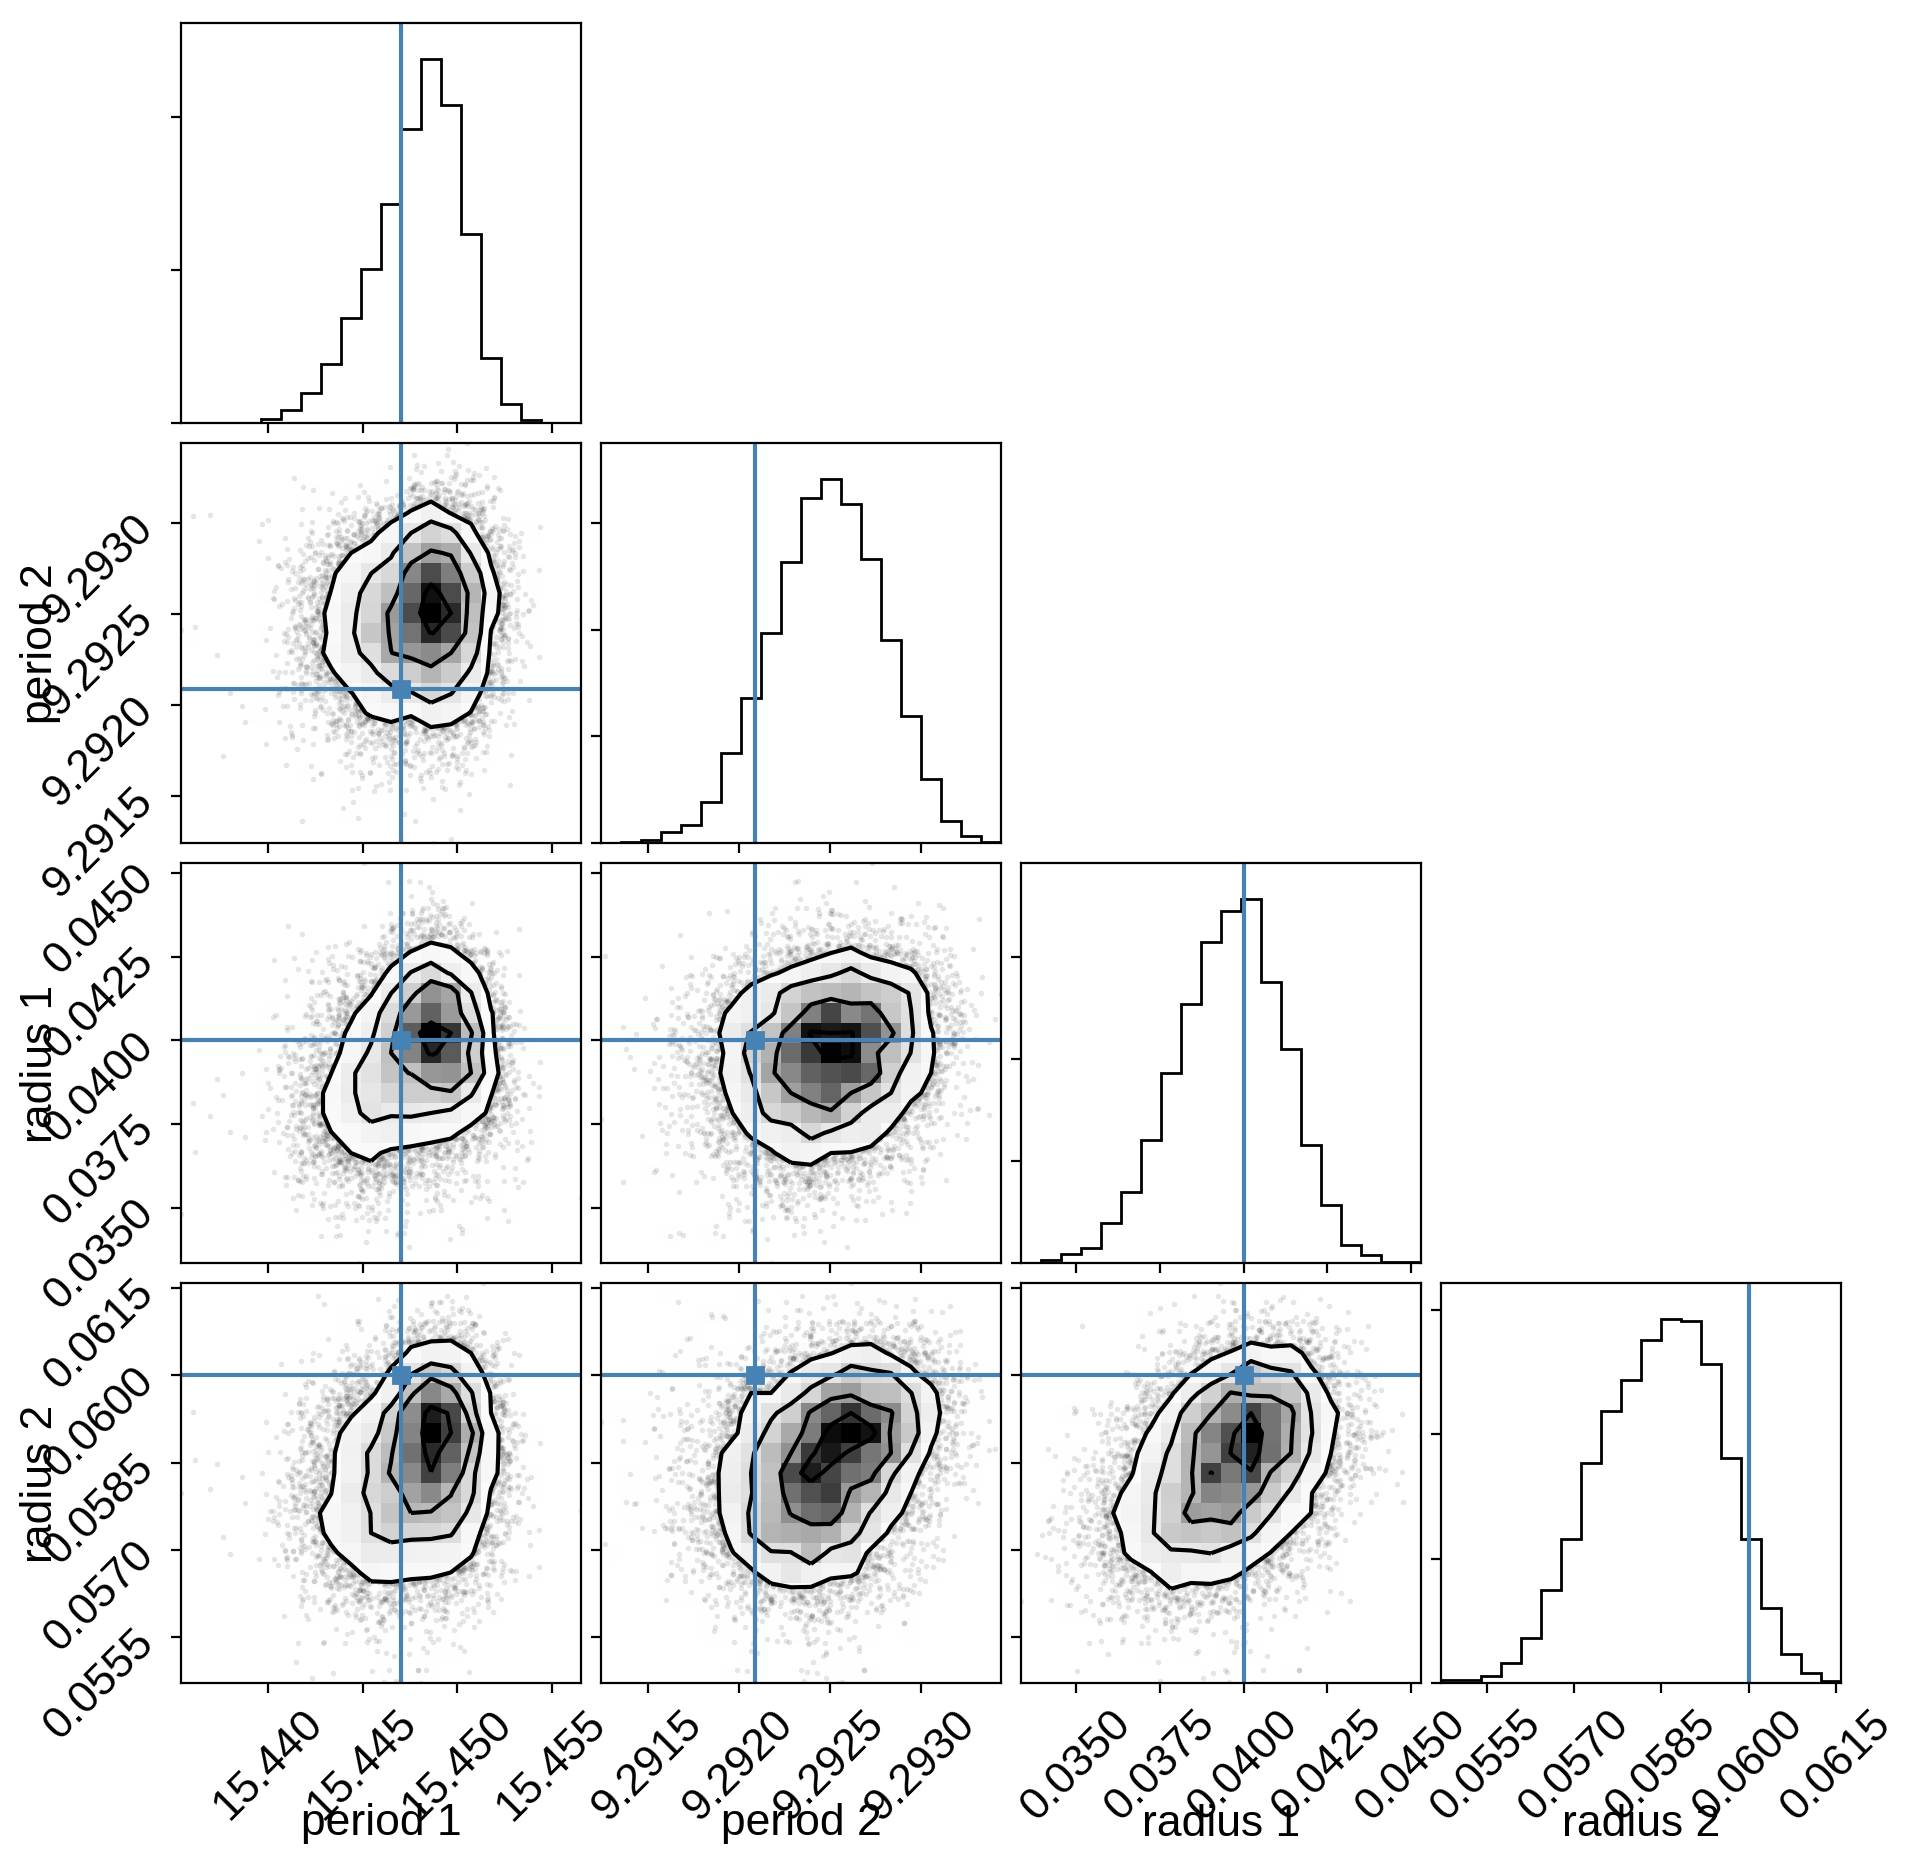

In [9]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(
    samples, truths=truth, labels=["period 1", "period 2", "radius 1", "radius 2"]
);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

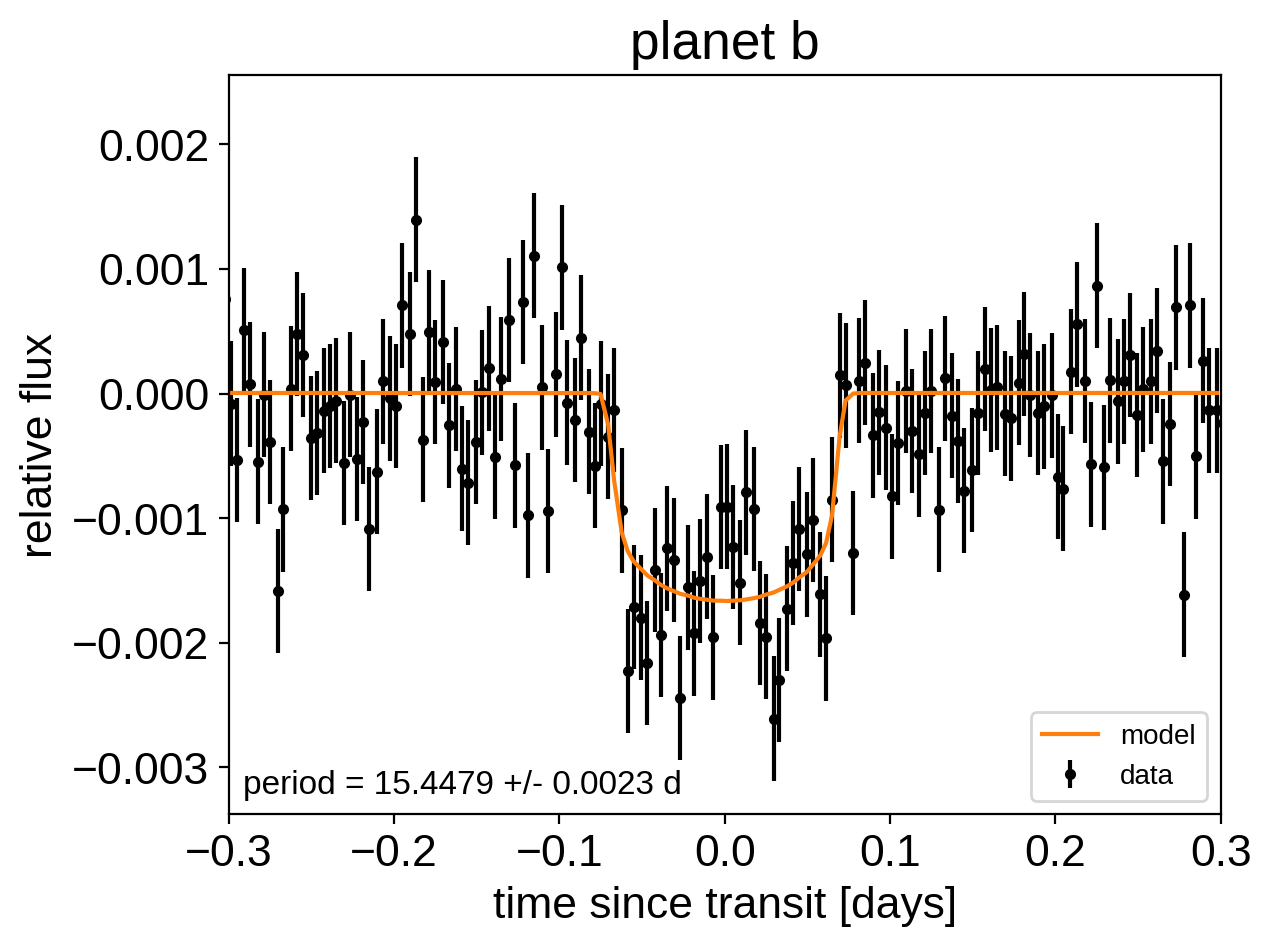

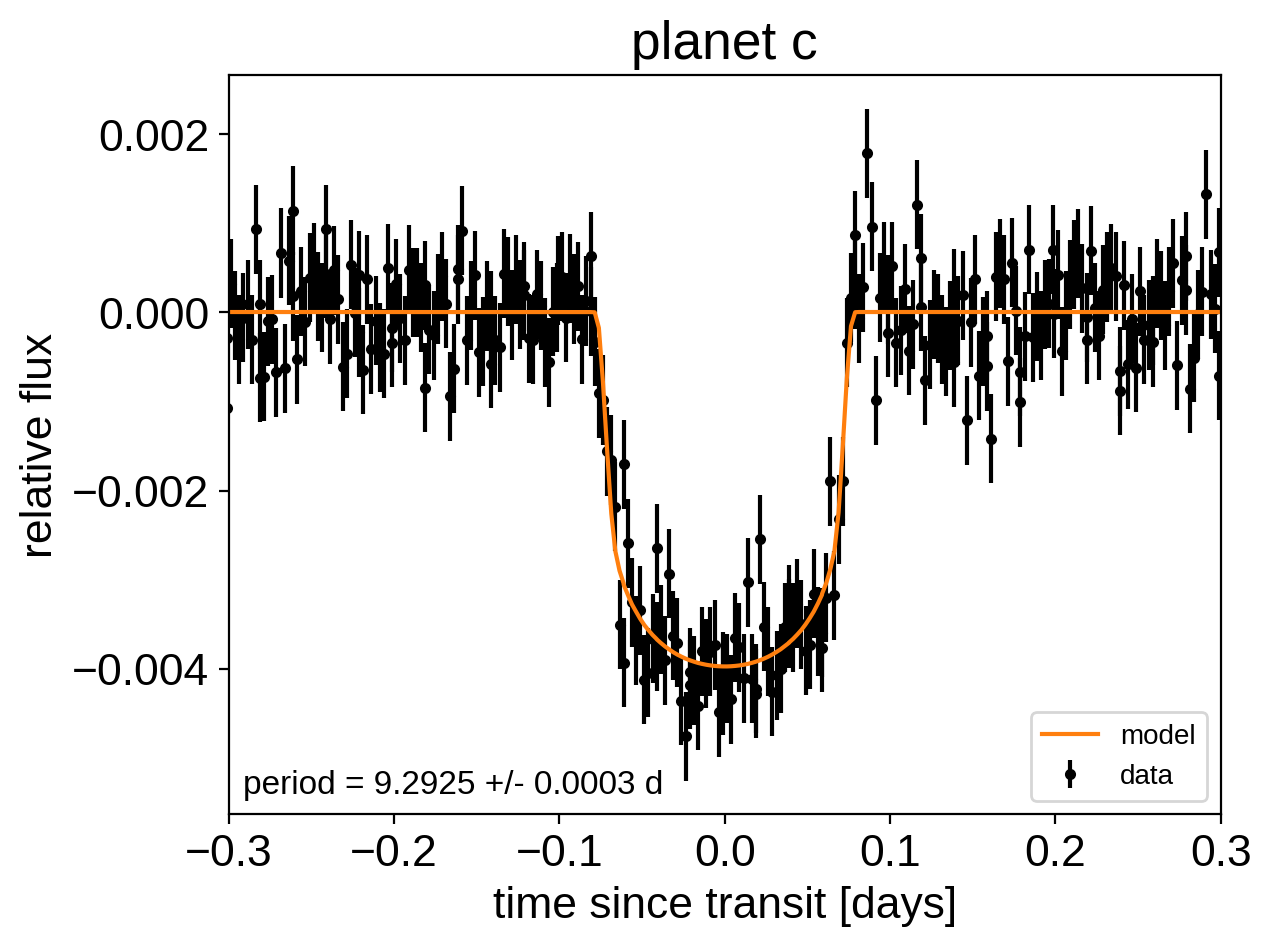

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet v0.2.3},
   month = nov,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
